In [157]:
import json
import os

results_dir = "results/"
json_files = [pos_json for pos_json in os.listdir(results_dir) if pos_json.endswith('.json')]

data = []
for index, json_fn in enumerate(json_files):
    with open(os.path.join(results_dir, json_fn)) as in_file:
        fusion_group = json_fn.removesuffix('.json')
        content = json.load(in_file)
        print(f'Read fusion group {fusion_group} with {len(content)} lines')
        data.extend(content)

Read fusion group A.D.E,B,C,F,G with 5891 lines
Read fusion group A,B,C,D,E,F,G with 6891 lines
Read fusion group A.B.D.E,C,F,G with 7824 lines
Read fusion group A.E,B,C,D,F,G with 6844 lines


In [158]:
# This is a single invocation
# data[0]

In [159]:
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline

df = pd.DataFrame.from_dict(data)

# Get the smallest Start timestamp and remove it from every timestamp value
min_start_timestamp = df["startTimestamp"].min()
df["startTimestamp"] = df["startTimestamp"] - min_start_timestamp
df["endTimestamp"] = df["endTimestamp"] - min_start_timestamp
df["duration"] =  df["endTimestamp"] - df["startTimestamp"]
df["fusionGroup"] = df["fusionGroup"].str.replace(",", "/")

df

,traceId,fusionGroup,source,currentFunction,billedDuration,maxMemoryUsed,isRootInvocation,startTimestamp,endTimestamp,internalDuration,calls,duration
0,e1cc551c64c11b9835fe7fbc8e07743d8b9a027945bf63...,A.D.E/B/C/F/G,A,A,3121,89,True,2579023,2582142,3117,"[{'called': 'C', 'caller': 'A', 'local': False...",3119
1,c7d82a37d508a74e11009cad03c703dce7524a4aee0b72...,A.D.E/B/C/F/G,A,A,3135,89,True,2582978,2586111,3133,"[{'called': 'C', 'caller': 'A', 'local': False...",3133
2,2c9880eaaffc1acb44891c3acb5089961f26ea0d23bf0c...,A.D.E/B/C/F/G,A,A,3140,89,True,2586986,2590126,3139,"[{'called': 'C', 'caller': 'A', 'local': False...",3140
3,37cd2292d65eb7d5bb2ab1d1f538b09b7da8f391e4f140...,A.D.E/B/C/F/G,A,A,3114,89,True,2590995,2594107,3112,"[{'called': 'C', 'caller': 'A', 'local': False...",3112
4,84f73ed0c77c39fbea2317911f23bd39f91b2cec422334...,A.D.E/B/C/F/G,A,A,3113,89,True,2595013,2598124,3110,"[{'called': 'C', 'caller': 'A', 'local': False...",3111
...,...,...,...,...,...,...,...,...,...,...,...,...
27445,b8c77fffaa4995318e273ec1e92ea696bfc9ec9798541d...,A.E/B/C/D/F/G,A,G,301,119,False,1385471,1385768,238,"[{'called': 'G', 'caller': 'G', 'local': True,...",297
27446,5d8ce2926b65b336472374bb87368b92be1754f17408eb...,A.E/B/C/D/F/G,A,G,421,120,False,1386225,1386585,340,"[{'called': 'G', 'caller': 'G', 'local': True,...",360
27447,473c01eb315175f9cea1fd20a50d27f96f3692e67859fa...,A.E/B/C/D/F/G,A,G,369,120,False,1387525,1387845,262,"[{'called': 'G', 'caller': 'G', 'local': True,...",320
27448,063c605b3a5117bb88717a1f7c730e7d07299ba0ad476a...,A.E/B/C/D/F/G,A,G,267,120,False,1388199,1388485,207,"[{'called': 'G', 'caller': 'G', 'local': True,...",286


In [160]:
print(f'Unique Invocations: {df["traceId"].nunique()}')

Unique Invocations: 5000


<AxesSubplot:ylabel='billedDuration'>

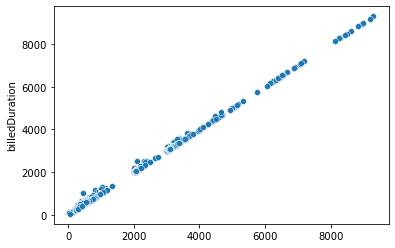

In [161]:
sns.scatterplot(data=df, x=df["endTimestamp"]-df["startTimestamp"], y="billedDuration")

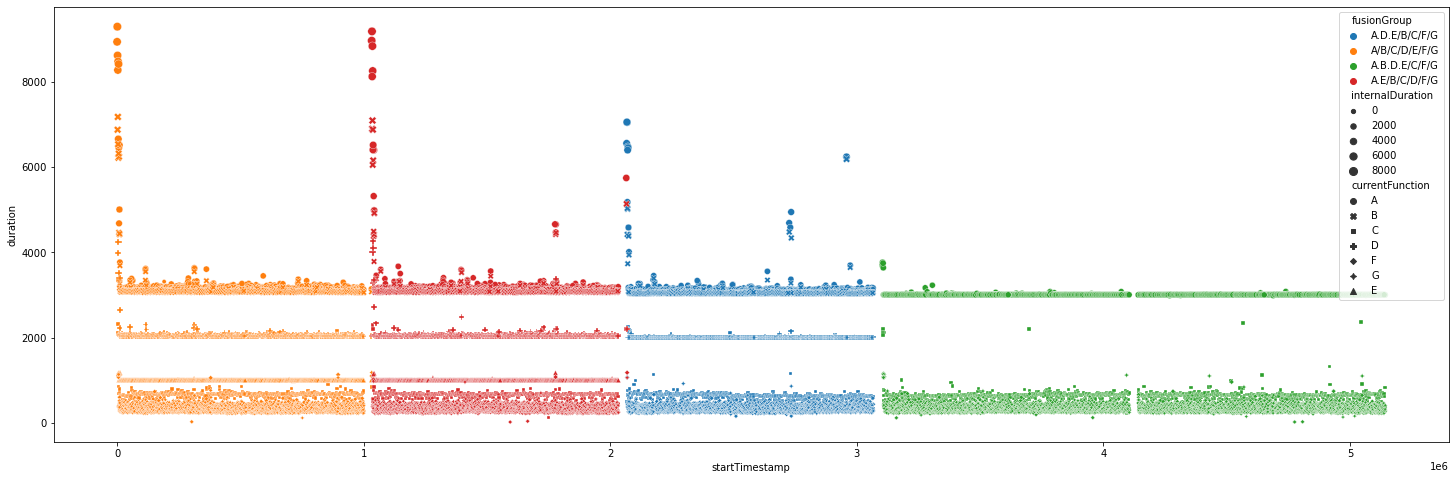

In [162]:
plt.figure(figsize=(25,8))
sns.scatterplot(data=df, x="startTimestamp", y="duration", size="internalDuration", hue=df["fusionGroup"], style="currentFunction")
plt.savefig("pointCloud.pdf")

<AxesSubplot:xlabel='startTimestamp', ylabel='10s_billedDuration_avg'>

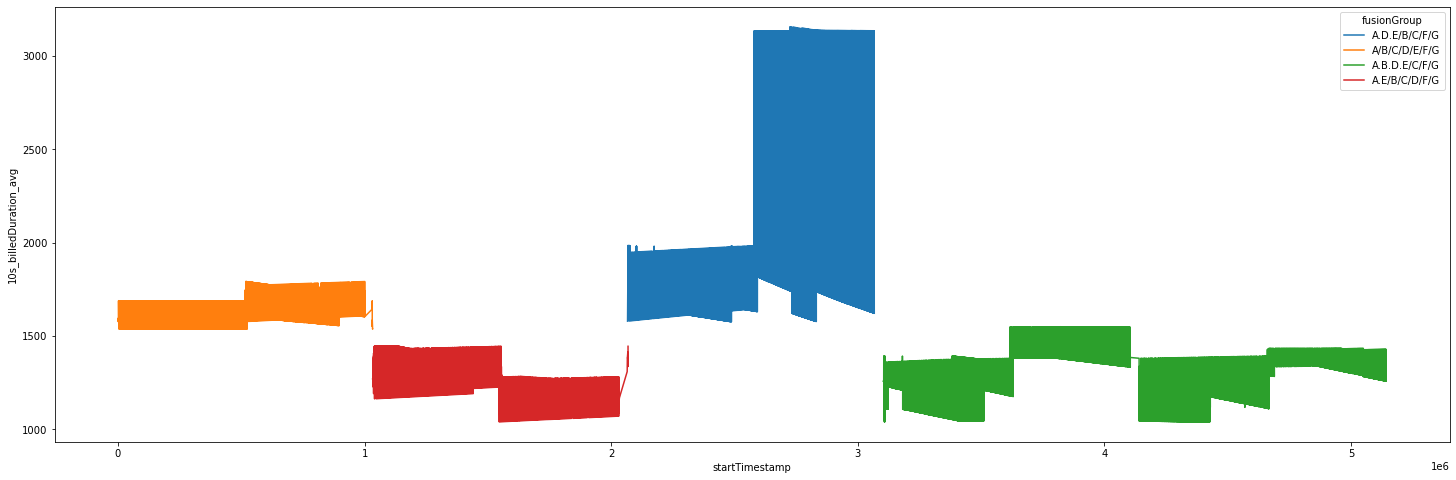

In [163]:
plt.figure(figsize=(25,8))
df['10s_billedDuration_avg'] = df['billedDuration'].rolling(10000, min_periods=30).mean()
#df['10s_billedDuration_med'] = df['billedDuration'].rolling(10000, min_periods=30).median()
sns.lineplot(data=df, x="startTimestamp", y="10s_billedDuration_avg", hue=df["fusionGroup"])
#sns.lineplot(data=df, x="startTimestamp", y="10s_billedDuration_med", hue=df["fusionGroup"])
#sns.scatterplot(data=df, x="startTimestamp", y="billedDuration", hue=df["fusionGroup"], legend=None)

In [164]:
# Now do not count every invocation, but sort the df by the cost of trace
grouped = df.groupby('traceId').agg({'billedDuration': ['sum'], 'startTimestamp': ['min'], 'endTimestamp': ['max'], 'fusionGroup': 'min'})
#grouped['numInvocations'] = df.groupby('traceId').count()
grouped['numInvocations'] = df.groupby('traceId').size()
print(f'Total Number of Invocations should be: {grouped["numInvocations"].sum()} == {len(df.index)}')

# Grouped: Get Root Invocation of TraceId and get rootEndTimestamp
# Pandas join() oder merge() machen mit dem alten Dataframe. Merge ist einfacher
rootInvocations = df[df["isRootInvocation"]][["traceId", "endTimestamp"]].rename(columns={"endTimestamp": "rootEndTimestamp"})
grouped = pd.merge(grouped, rootInvocations, how="left", on="traceId")
grouped["rootDuration"] = grouped["rootEndTimestamp"] - grouped["startTimestamp", "min"]

grouped

Total Number of Invocations should be: 27450 == 27450


/tmp/ipykernel_196947/2807751757.py:10: FutureWarning: merging between different levels is deprecated and will be removed in a future version. (2 levels on the left, 1 on the right)
  grouped = pd.merge(grouped, rootInvocations, how="left", on="traceId")


,traceId,"(billedDuration, sum)","(startTimestamp, min)","(endTimestamp, max)","(fusionGroup, min)","(numInvocations, )",rootEndTimestamp,rootDuration
0,001c71d9d8c21c0d7543cb730132ceec5e82953bd8683e...,4210,3254900,3257921,A.B.D.E/C/F/G,4,3257921.0,3021.0
1,0022cbc30904cf9595afc98748e3ad72741cc322344be9...,8411,146578,149697,A/B/C/D/E/F/G,6,149697.0,3119.0
2,00435a7c9e8183535c33ba53d7ce0da52370bf3fa08f0b...,4120,3818399,3821404,A.B.D.E/C/F/G,4,3821404.0,3005.0
3,0048e1d6d64622abf6a47e46b8d51ccc3a84c8c39ab919...,4077,4827478,4830484,A.B.D.E/C/F/G,4,4830484.0,3006.0
4,00497f2ebe82dffd4ff17540a1b93afe1d072aabd4f2b9...,4519,3865522,3868527,A.B.D.E/C/F/G,4,3868527.0,3005.0
...,...,...,...,...,...,...,...,...
4995,ffc875521eb88e0ad59965afa5ade2a8e5e429e8ba13c6...,10430,159572,162766,A/B/C/D/E/F/G,7,162766.0,3194.0
4996,ffd40547d751b81cae3104b3ed3e9b6247777e03b869a8...,3751,4316149,4319161,A.B.D.E/C/F/G,3,4319161.0,3012.0
4997,ffd96e6ee43caee51ef1c05f72840b5727511657164fdf...,4124,4934718,4937725,A.B.D.E/C/F/G,4,4937725.0,3007.0
4998,ffdf3d8d7d51a02582af9c2c4c7afcfc225583a9638267...,8078,1533037,1536284,A.E/B/C/D/F/G,6,1536284.0,3247.0


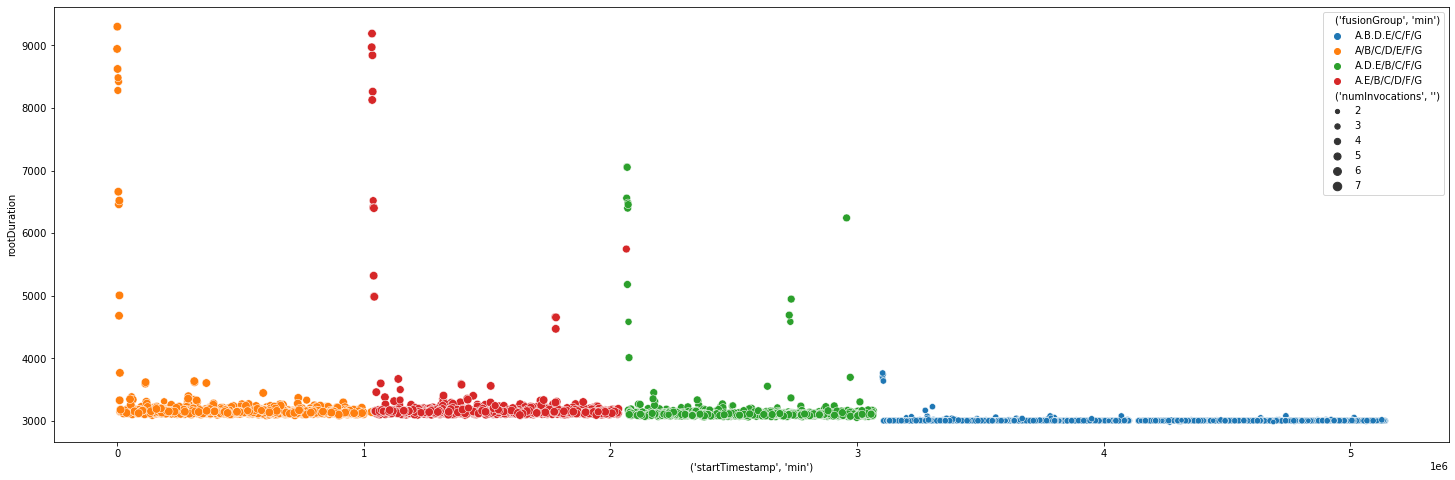

In [165]:
plt.figure(figsize=(25,8))
sns.scatterplot(data=grouped, x=grouped['startTimestamp', 'min'] , y=grouped['rootDuration'], hue=grouped['fusionGroup', 'min'], size=grouped["numInvocations", ""])
plt.savefig("duration.pdf")

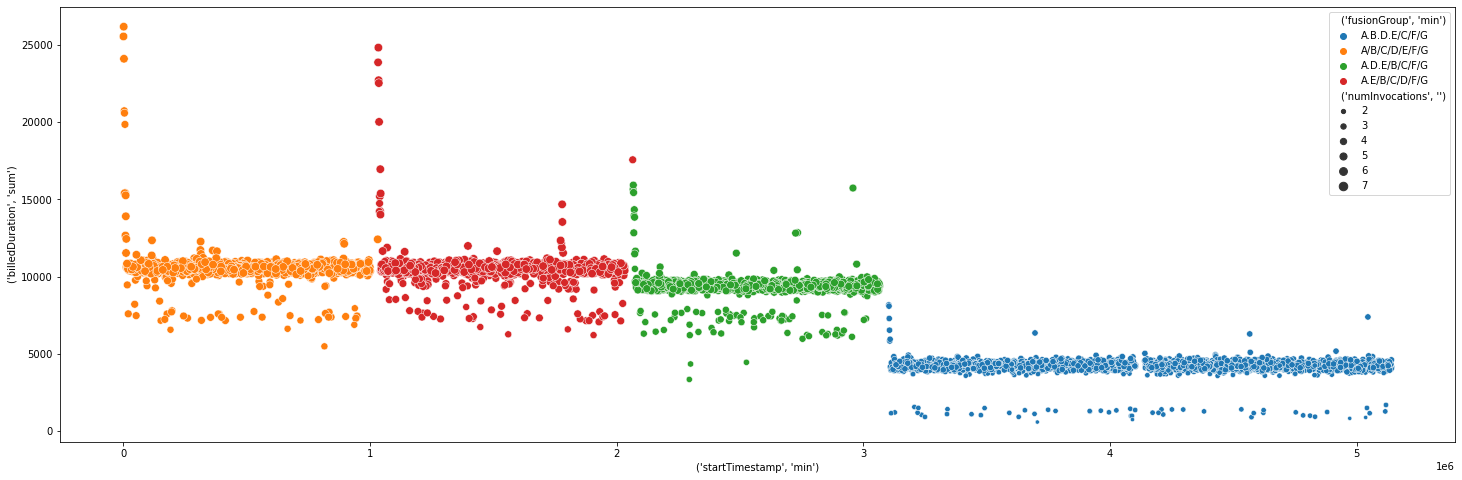

In [166]:
plt.figure(figsize=(25,8))
sns.scatterplot(data=grouped, x=grouped['startTimestamp', 'min'] , y=grouped['billedDuration', 'sum'], hue=grouped['fusionGroup', 'min'], size=grouped["numInvocations", ""])
plt.savefig("billed.pdf")

In [167]:
grouped[grouped["rootDuration"] <= 1000]

,traceId,"(billedDuration, sum)","(startTimestamp, min)","(endTimestamp, max)","(fusionGroup, min)","(numInvocations, )",rootEndTimestamp,rootDuration


['A/B/C/D/E/F/G' 'A.E/B/C/D/F/G' 'A.D.E/B/C/F/G' 'A.B.D.E/C/F/G']


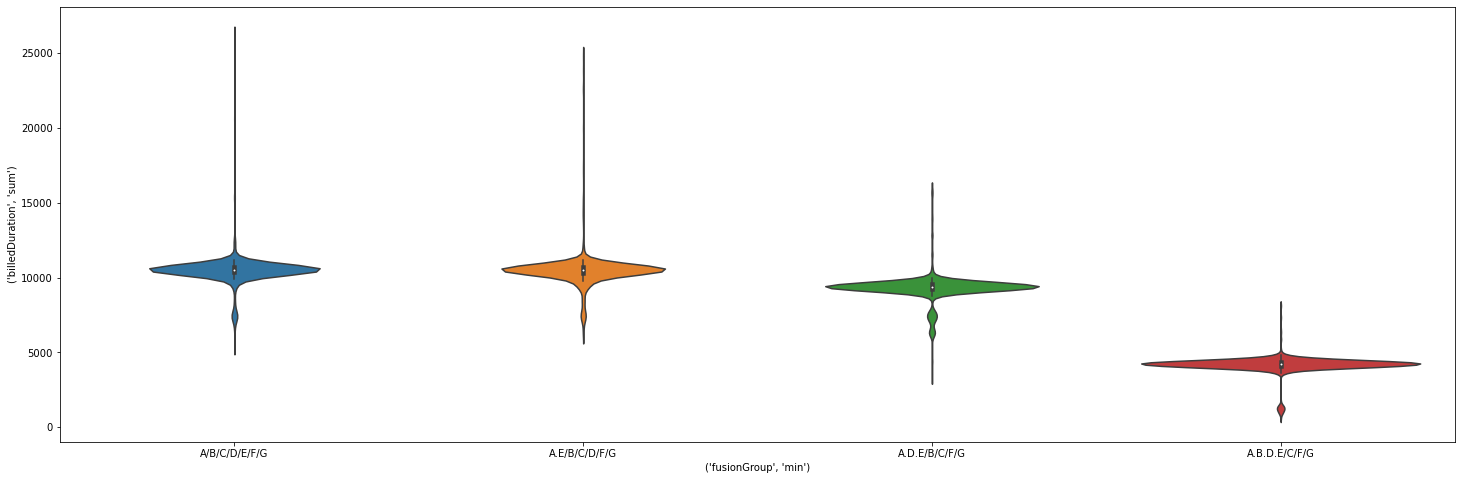

In [168]:
plt.figure(figsize=(25,8))
fusion_groups_order = pd.unique(grouped.sort_values(by="rootEndTimestamp")['fusionGroup', 'min'])
print(fusion_groups_order)
sns.violinplot(data=grouped, x=grouped['fusionGroup', 'min'] , y=grouped['billedDuration', 'sum'], order=fusion_groups_order)
plt.savefig("violinBilled.pdf")

['A/B/C/D/E/F/G' 'A.E/B/C/D/F/G' 'A.D.E/B/C/F/G' 'A.B.D.E/C/F/G']


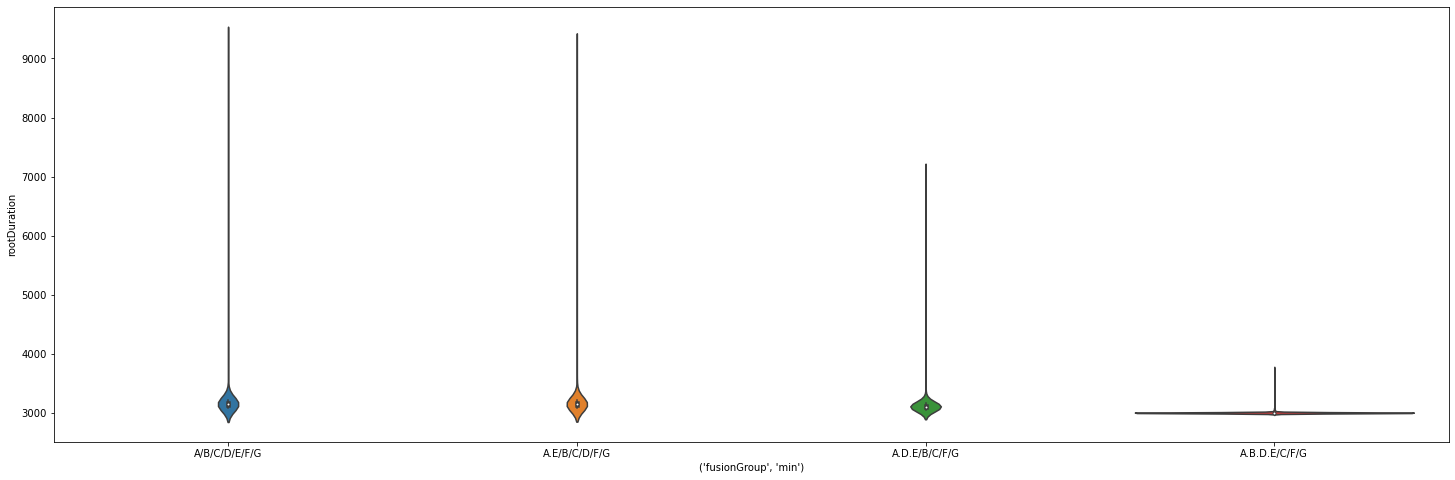

In [169]:
plt.figure(figsize=(25,8))
fusion_groups_order = pd.unique(grouped.sort_values(by="rootEndTimestamp")['fusionGroup', 'min'])
print(fusion_groups_order)
sns.violinplot(data=grouped, x=grouped['fusionGroup', 'min'] , y=grouped['rootDuration'], order=fusion_groups_order)
plt.savefig("violinRR.pdf")

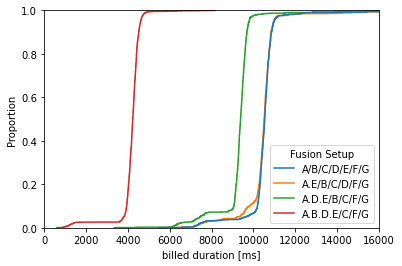

In [176]:
ax = sns.ecdfplot(data=grouped, x=grouped['billedDuration', 'sum'], hue=grouped['fusionGroup', 'min'], hue_order=fusion_groups_order)
plt.xlabel("billed duration [ms]")
ax.get_legend().set_title("Fusion Setup")
ax.set(xlim=(000,16000))
plt.savefig("ecdfBilled.pdf")

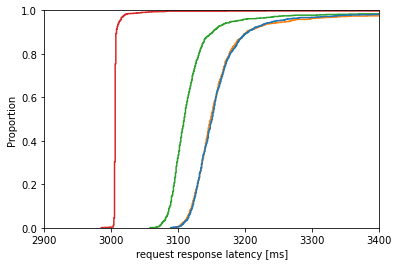

In [177]:
ax = sns.ecdfplot(data=grouped, x=grouped['rootDuration'], hue=grouped['fusionGroup', 'min'], hue_order=fusion_groups_order, legend=None)
plt.xlabel("request response latency [ms]")
#ax.get_legend().set_title("Fusion Group")
ax.set(xlim=(2900,3400))
plt.savefig("ecdfRR.pdf")

In [172]:
from scipy.stats import t

In [173]:
# Calculate Mean and Confidence Interval of billed duration and rootDuration

def printMeanAndCi(x, name=""):
    m = x.mean() 
    s = x.std() 
    dof = len(grouped)-1 
    confidence = 0.95

    t_crit = np.abs(t.ppf((1-confidence)/2,dof))
    print(f'Mean: {m:7.2f}, Confidence Interval: ({m-s*t_crit/np.sqrt(len(x)):7.2f} / {m+s*t_crit/np.sqrt(len(x)):7.2f}), Median: {x.median()} for {name}')

print("overall")
printMeanAndCi(grouped["rootDuration"], "rootDuration")
printMeanAndCi(grouped['billedDuration', 'sum'], "billedDuration")
for group in fusion_groups_order:
    filtered = grouped[grouped['fusionGroup', 'min'] == group]
    print(group)
    printMeanAndCi(filtered["rootDuration"], f'rootDuration')
    printMeanAndCi(filtered['billedDuration', 'sum'], f'billedDuration')

overall
Mean: 3118.36, Confidence Interval: (3108.77 / 3127.95), Median: 3108.0 for rootDuration
Mean: 7726.40, Confidence Interval: (7640.96 / 7811.84), Median: 9323.0 for billedDuration
A/B/C/D/E/F/G
Mean: 3206.82, Confidence Interval: (3177.40 / 3236.24), Median: 3151.0 for rootDuration
Mean: 10520.79, Confidence Interval: (10445.12 / 10596.47), Median: 10539.0 for billedDuration
A.E/B/C/D/F/G
Mean: 3212.63, Confidence Interval: (3183.36 / 3241.89), Median: 3149.0 for rootDuration
Mean: 10473.37, Confidence Interval: (10398.01 / 10548.73), Median: 10510.0 for billedDuration
A.D.E/B/C/F/G
Mean: 3150.64, Confidence Interval: (3130.78 / 3170.50), Median: 3109.0 for rootDuration
Mean: 9291.96, Confidence Interval: (9236.67 / 9347.24), Median: 9383.0 for billedDuration
A.B.D.E/C/F/G
Mean: 3008.86, Confidence Interval: (3007.26 / 3010.46), Median: 3006.0 for rootDuration
Mean: 4172.31, Confidence Interval: (4147.51 / 4197.12), Median: 4232.0 for billedDuration
